# Quejas de productos financieros

Realizamos un análisis de datos sobre una base con registros de quejas de productos financieros en Estados Unidos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import datetime

from sklearn.cluster import DBSCAN

from wordcloud import WordCloud

import editdistance
import time

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
palabras_inutiles = stopwords.words('english')

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows',None)

## Carga de datos

Para nuestro ejercicio ocupamos:
- Una base de quejas de productos financieros
- Un mapa de los Estados Unidos
- Una base con información de los zip codes. 

In [3]:
df=pd.read_csv('inputs/Consumer_Complaints.csv')
df.head()

Date received                  Product                  Sub-product  \
0    07/29/2013            Consumer Loan                 Vehicle loan   
1    07/29/2013  Bank account or service             Checking account   
2    07/29/2013  Bank account or service             Checking account   
3    07/29/2013  Bank account or service             Checking account   
4    07/29/2013                 Mortgage  Conventional fixed mortgage   

                                      Issue Sub-issue  \
0                Managing the loan or lease       NaN   
1                 Using a debit or ATM card       NaN   
2   Account opening, closing, or management       NaN   
3                  Deposits and withdrawals       NaN   
4  Loan servicing, payments, escrow account       NaN   

  Consumer complaint narrative Company public response  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN                     NaN   
3                          NaN                     NaN   
4                          NaN                     NaN   

                      Company State ZIP code            Tags  \
0       Wells Fargo & Company    VA    24540             NaN   
1       Wells Fargo & Company    CA    95992  Older American   
2           Santander Bank US    NY    10065             NaN   
3       Wells Fargo & Company    GA    30084             NaN   
4  Franklin Credit Management    CT    06106             NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0                        NaN         Phone           07/30/2013   
1                        NaN           Web           07/31/2013   
2                        NaN           Fax           07/31/2013   
3                        NaN           Web           07/30/2013   
4                        NaN           Web           07/30/2013   

  Company response to consumer Timely response? Consumer disputed?  \
0      Closed with explanation              Yes                 No   
1      Closed with explanation              Yes                 No   
2                       Closed              Yes                 No   
3      Closed with explanation              Yes                 No   
4      Closed with explanation              Yes                 No   

   Complaint ID  
0        468882  
1        468889  
2        468879  
3        468949  
4        475823

In [4]:
mapa=gpd.read_file('inputs/cb_2018_us_state_5m')
mapa.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      31  01779792  0400000US31    31     NE      Nebraska   00   
1      53  01779804  0400000US53    53     WA    Washington   00   
2      35  00897535  0400000US35    35     NM    New Mexico   00   
3      46  01785534  0400000US46    46     SD  South Dakota   00   
4      48  01779801  0400000US48    48     TX         Texas   00   

          ALAND       AWATER  \
0  198956658395   1371829134   
1  172112588220  12559278850   
2  314196306401    728776523   
3  196346981786   3382720225   
4  676653171537  19006305260   

                                            geometry  
0  POLYGON ((-104.053514 41.157257, -104.052666 4...  
1  (POLYGON ((-122.328343 48.021335, -122.321721 ...  
2  POLYGON ((-109.050173 31.480004, -109.049843 3...  
3  POLYGON ((-104.057698 44.997431, -104.05021 44...  
4  POLYGON ((-106.645479 31.89867, -106.64084 31....

In [5]:
zip_data=pd.read_csv('inputs/zip_code_database.csv')[['zip','latitude','longitude']]
zip_data.head()

zip  latitude  longitude
0  501     40.81     -73.04
1  544     40.81     -73.04
2  601     18.16     -66.72
3  602     18.38     -67.18
4  603     18.43     -67.15

## Transformaciones

In [6]:
df['company_0']=df['Company'].copy().str.upper()
df['company_0']=df['company_0']\
    .str.replace(' C\.O','').str.replace(' P\.A','').str.replace(' CO\.','').str.replace('PA\.','')
df['company_0']=df['company_0']\
    .str.replace('\.','').str.replace(',','').str.replace('  ',' ')
df['company_0']=df['company_0']\
    .str.replace(' INC','').str.replace(' LLC','').str.replace(' LLP','')\
    .str.replace(' PLC','').str.replace(' PLLC','').str.replace(' LLP','')\
    .str.replace(' PS','').str.replace(' LC','').str.replace(' PL','').str.replace(' SA RL','').str.replace(' LTD','')\
    .str.replace(' LP','').str.replace(' PC','')

df['zip']=pd.to_numeric(df['ZIP code'],errors='coerce',downcast='integer')
df['zip']=df['zip'].astype('int64',errors='ignore')

df['date']=df['Date received'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))

df['date_year']=df['date'].dt.strftime('%Y-%m')

In [7]:
df=df.merge(zip_data,on='zip',how='left')

In [8]:
puntos = gpd.GeoDataFrame(df[['Complaint ID','State','Product','latitude','longitude','zip']],
                          geometry=gpd.points_from_xy(df['longitude'],
                                                      df['latitude']))
#puntos=puntos[puntos.is_valid]

## Análisis exploratorio de datos

Primero volvemos a mostrar una parte de la base para darnos una idea rápida de la información que contiene. En ella podemos observar que hay información de identificación espacial y temporal.

Además de esto, cada registro tiene información sobre el producto, el banco proveedor, y variables sobre el seguimiento del caso.

Posterior a esto pasaremos a ver el número de registros únicos por proveedor, con el objetivo de ver a grandes rasgos que tan factible es scsdcsdcsd, y el número de registros ocn información faltante para cada categoría, para tenerlo en consideración.

In [9]:
df.head()

Date received                  Product                  Sub-product  \
0    07/29/2013            Consumer Loan                 Vehicle loan   
1    07/29/2013  Bank account or service             Checking account   
2    07/29/2013  Bank account or service             Checking account   
3    07/29/2013  Bank account or service             Checking account   
4    07/29/2013                 Mortgage  Conventional fixed mortgage   

                                      Issue Sub-issue  \
0                Managing the loan or lease       NaN   
1                 Using a debit or ATM card       NaN   
2   Account opening, closing, or management       NaN   
3                  Deposits and withdrawals       NaN   
4  Loan servicing, payments, escrow account       NaN   

  Consumer complaint narrative Company public response  \
0                          NaN                     NaN   
1                          NaN                     NaN   
2                          NaN                     NaN   
3                          NaN                     NaN   
4                          NaN                     NaN   

                      Company State ZIP code    ...      \
0       Wells Fargo & Company    VA    24540    ...       
1       Wells Fargo & Company    CA    95992    ...       
2           Santander Bank US    NY    10065    ...       
3       Wells Fargo & Company    GA    30084    ...       
4  Franklin Credit Management    CT    06106    ...       

  Company response to consumer Timely response? Consumer disputed?  \
0      Closed with explanation              Yes                 No   
1      Closed with explanation              Yes                 No   
2                       Closed              Yes                 No   
3      Closed with explanation              Yes                 No   
4      Closed with explanation              Yes                 No   

  Complaint ID                   company_0      zip       date  date_year  \
0       468882       WELLS FARGO & COMPANY  24540.0 2013-07-29    2013-07   
1       468889       WELLS FARGO & COMPANY  95992.0 2013-07-29    2013-07   
2       468879           SANTANDER BANK US  10065.0 2013-07-29    2013-07   
3       468949       WELLS FARGO & COMPANY  30084.0 2013-07-29    2013-07   
4       475823  FRANKLIN CREDIT MANAGEMENT   6106.0 2013-07-29    2013-07   

  latitude  longitude  
0    36.63     -79.43  
1    39.02    -121.61  
2    40.76     -73.96  
3    33.85     -84.22  
4    41.76     -72.68  

[5 rows x 24 columns]

In [10]:
df.nunique()

Date received                     1818
Product                             12
Sub-product                         47
Issue                               95
Sub-issue                           68
Consumer complaint narrative    112690
Company public response             10
Company                           3933
State                               62
ZIP code                         27889
Tags                                 3
Consumer consent provided?           4
Submitted via                        6
Date sent to company              1767
Company response to consumer         8
Timely response?                     2
Consumer disputed?                   2
Complaint ID                    670598
company_0                         3927
zip                              26849
date                              1818
date_year                           60
latitude                          2486
longitude                         4997
dtype: int64

In [11]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

Tags                            85.873802
Consumer complaint narrative    82.895267
Company public response         78.348131
Consumer consent provided?      68.960391
Sub-issue                       59.757112
Sub-product                     29.556008
latitude                        19.775335
longitude                       19.775335
zip                             19.562092
Consumer disputed?               6.176428
ZIP code                         0.793918
State                            0.791085
Timely response?                 0.000000
Company response to consumer     0.000000
Date sent to company             0.000000
Submitted via                    0.000000
Complaint ID                     0.000000
Company                          0.000000
company_0                        0.000000
date                             0.000000
Issue                            0.000000
date_year                        0.000000
Product                          0.000000
Date received                    0

De aquí salta a la vista que únicamente 17% de los registros contienen comentarios. Desplegando la información a lo largo del tiempo, podemos observar que todos esos registros son de los últimos dos años. Es probable que hasta ese momento se haya dado la opción de registrar comentarios, y que de ahora en adelante se conserve dicha funcionalidad.

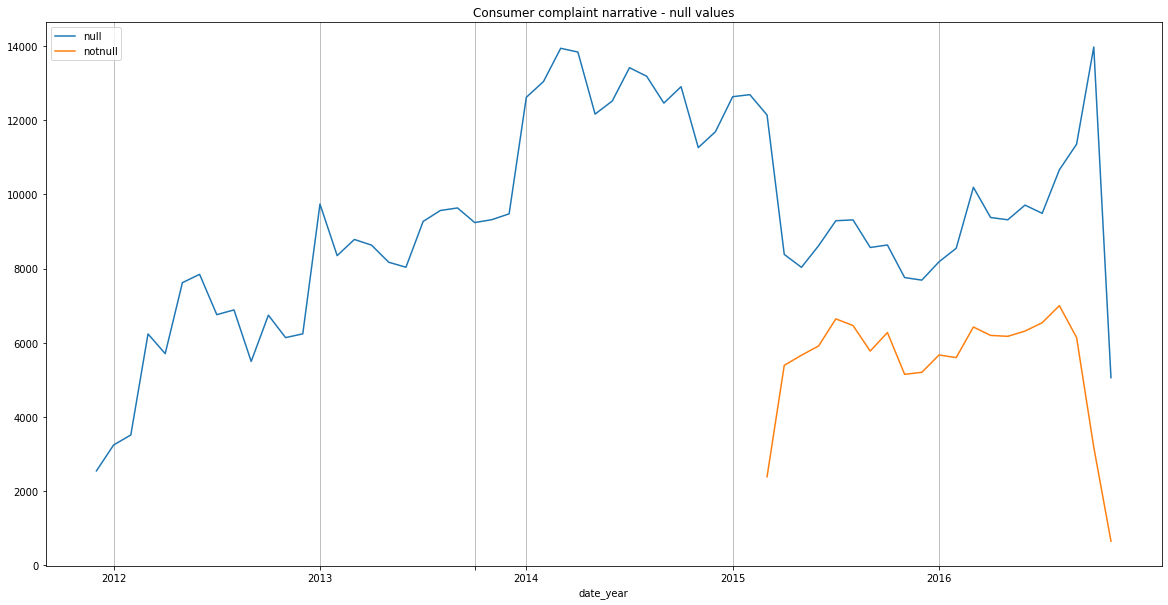

In [12]:
plt.figure(figsize=(20,10))
plt.grid(axis='x')

plt.plot(df[df['Consumer complaint narrative'].isnull()].groupby('date_year').size(),label='null')
plt.plot(df[df['Consumer complaint narrative'].notnull()].groupby('date_year').size(),label='notnull')

plt.xlabel('date_year')
plt.xticks(['2012-01','2013-01','2014-01','2015-01','2016-01','2013-10'],['2012','2013','2014','2015','2016'])
plt.title('Consumer complaint narrative - null values')
plt.legend()
plt.show()

Ahora pasamos a revisar las métricas de seguimiento de los casos.
Volviendo al porcentaje de registros sin información, vemos que todos ellos, salvo "Company public response", tienen información para casi la totalidad de registros, por lo que nos pueden dar una imagen completa de las cosas.

Si bien los gráficos pie tienen defectos de percepción, son útiles cuando hay pocas categorías o el mayor porcentaje de casos se concentra en pocas de ellas.

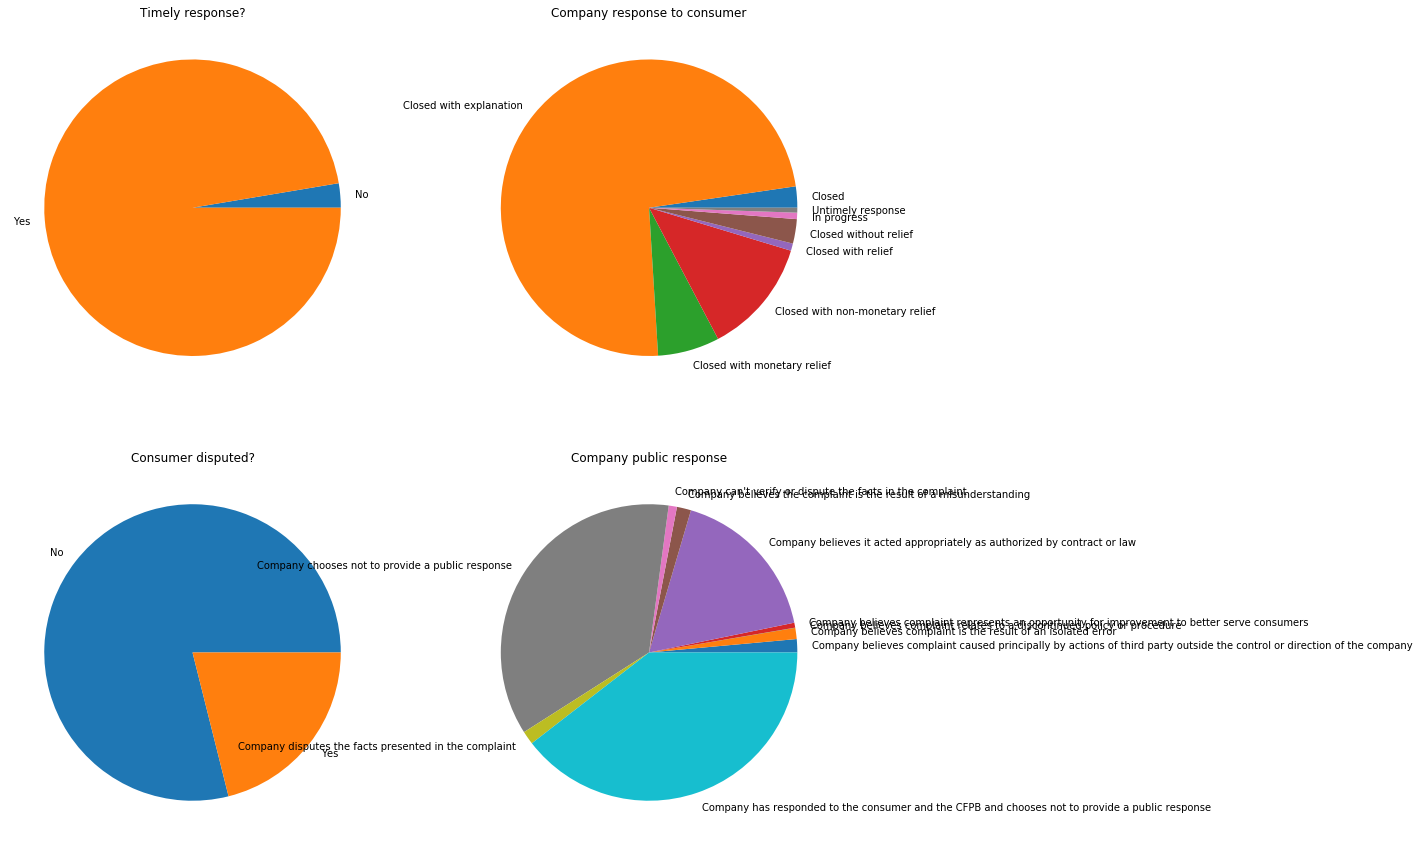

In [13]:
plt.figure(figsize=(15,15))

ax = plt.subplot(2,2,1)
df.groupby('Timely response?').size().plot('pie',ax=ax)
ax.set_title('Timely response?')
ax.set_ylabel(None)

ax = plt.subplot(2,2,2)
df.groupby('Company response to consumer').size().plot('pie',ax=ax)
ax.set_title('Company response to consumer')
ax.set_ylabel(None)

ax = plt.subplot(2,2,3)
df.groupby('Consumer disputed?').size().plot('pie',ax=ax)
ax.set_title('Consumer disputed?')
ax.set_ylabel(None)

ax = plt.subplot(2,2,4)
df.groupby('Company public response').size().plot('pie',ax=ax)
ax.set_title('Company public response')
ax.set_ylabel(None)

plt.show()

Dado que las variables "Company response to consumer" y "Consumer disputed?" se ven sospechosamente similares, pasamos a examinar con mayor cuidado la composición conjunta de los registros entre estas categorías en caso de que exista una correlación. Podemos observar que no es el caso.

Por último, desplegamos los registros en el tiempo para evaluar la posibilidad de que la mayoría de las quejas se encuentren concentradas en algún punto del tiempo y esto pueda reflejar un deterioro en el servicio. Los datos no apoyan esta hipótesis, pues vemos que la distribución de ambos casos se mantienen estables en el tiempo.

In [14]:
df.groupby('Consumer disputed?')['Company response to consumer'].value_counts(normalize=True)*100

Consumer disputed?  Company response to consumer   
No                  Closed with explanation            72.260739
                    Closed with non-monetary relief    14.214669
                    Closed with monetary relief         7.696600
                    Closed without relief               2.609645
                    Closed                              2.308919
                    Closed with relief                  0.909428
Yes                 Closed with explanation            81.937715
                    Closed with non-monetary relief     7.712884
                    Closed with monetary relief         3.692931
                    Closed without relief               3.626623
                    Closed                              2.494104
                    Closed with relief                  0.534236
                    Untimely response                   0.001507
Name: Company response to consumer, dtype: float64

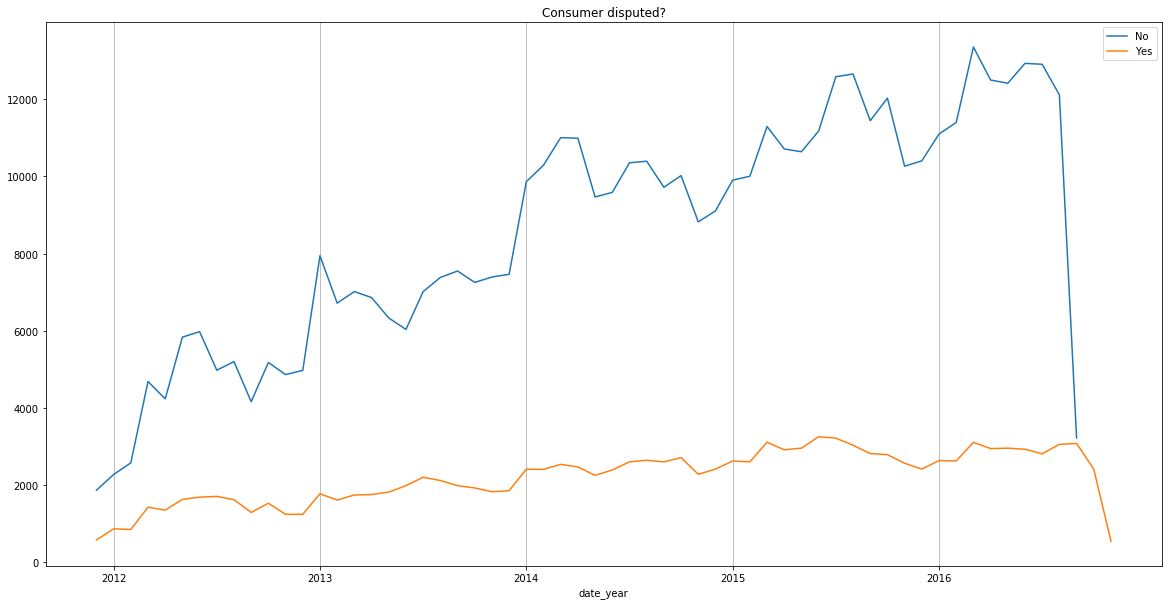

In [15]:
plt.figure(figsize=(20,10))
plt.grid(axis='x')

aux=df.groupby('Consumer disputed?').size().sort_values(ascending=False).index

for i in range(len(aux)):
    plt.plot(df[df['Consumer disputed?']==aux[i]].groupby('date_year').size(),label=aux[i])

plt.xlabel('date_year')
plt.xticks(['2012-01','2013-01','2014-01','2015-01','2016-01'],['2012','2013','2014','2015','2016'])
plt.title('Consumer disputed?')
plt.legend()
plt.show()

### Distribución temporal

Para empezar, es claro que la tendencia de registros ha sido a la alza de manera constante. La caída en el último punto probablemente se deba a una falta de registros para el mes más reciente, ocasionados por una fecha de corte

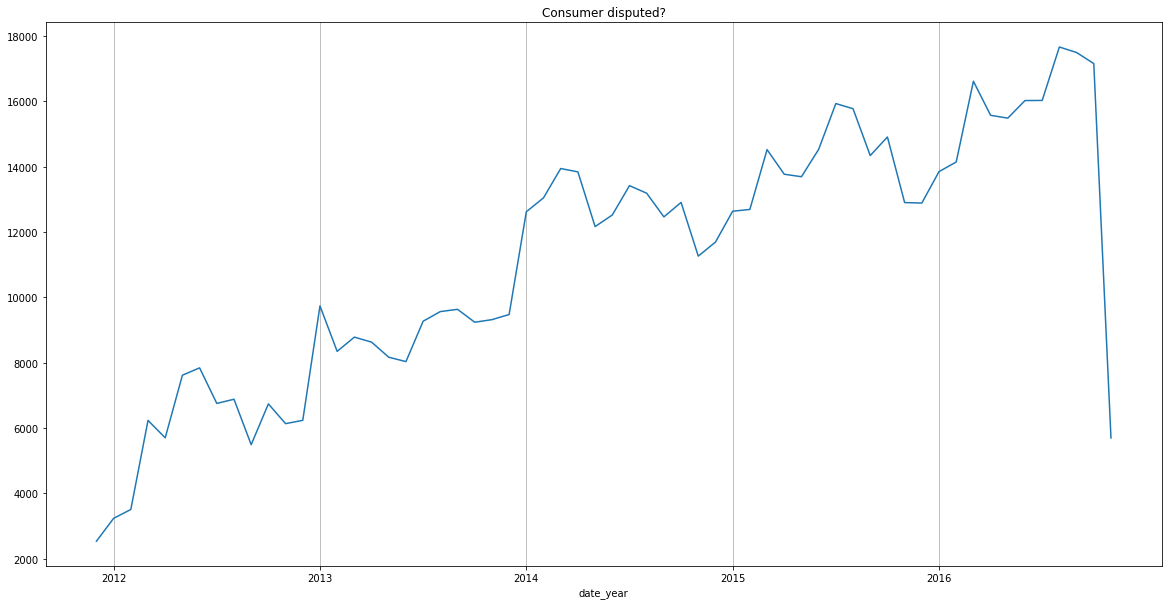

In [16]:
plt.figure(figsize=(20,10))
plt.grid(axis='x')

plt.plot(df.groupby('date_year').size())

plt.xlabel('date_year')
plt.xticks(['2012-01','2013-01','2014-01','2015-01','2016-01'],['2012','2013','2014','2015','2016'])
plt.title('Consumer disputed?')
plt.show()

Pasando a ver la evoluciónede registros segmentados por producto y por estado, también es claro que no hay grandes cambios en tendencias, apuntando a que los productos se encuentran establecidos en el mercado desde hace tiempo (de lo contrario podríamos ver una tendencia a la alza de los introducidos recientemente), mientras que con los estados esto significa que no ha habido una expansión especial en ninguno de ellos o, en su caso, una alza especial de quejas por mal servicio en una zona en particular.

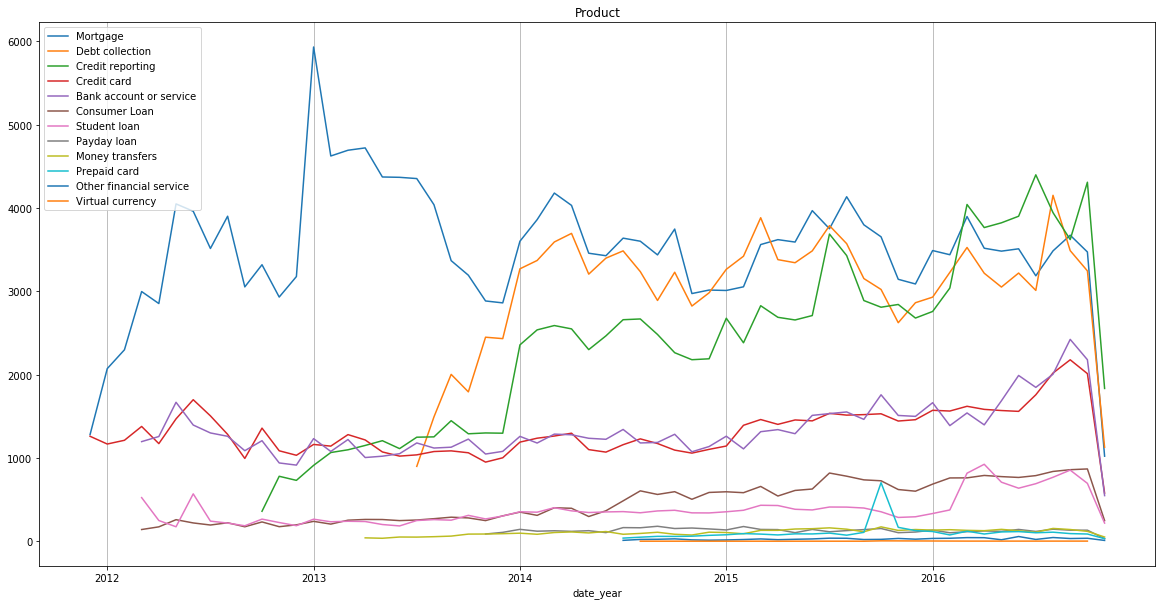

In [17]:
plt.figure(figsize=(20,10))
plt.grid(axis='x')
aux=df.groupby('Product').size().sort_values(ascending=False).index
for i in range(len(aux)):
    plt.plot(df[df['Product']==aux[i]].groupby('date_year').size(),label=aux[i])
plt.xlabel('date_year')
plt.xticks(['2012-01','2013-01','2014-01','2015-01','2016-01'],['2012','2013','2014','2015','2016'])
plt.title('Product')
plt.legend()
plt.show()

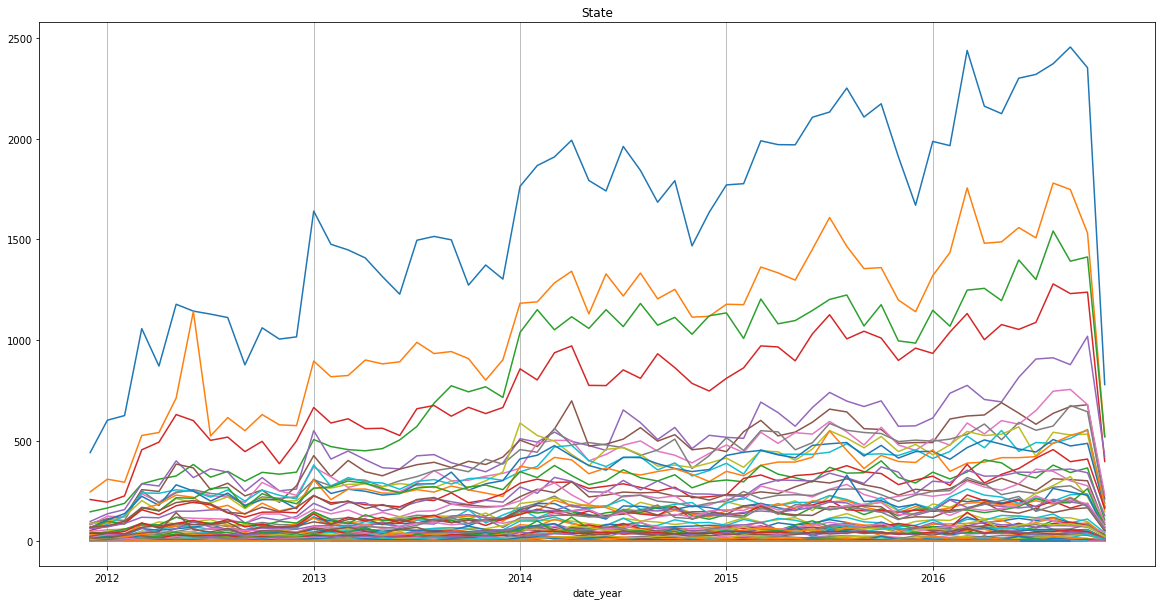

In [18]:
plt.figure(figsize=(20,10))
plt.grid(axis='x')
aux=df.groupby('State').size().sort_values(ascending=False).index
for i in range(len(aux)):
    plt.plot(df[df['State']==aux[i]].groupby('date_year').size(),label=aux[i])
plt.xlabel('date_year')
plt.xticks(['2012-01','2013-01','2014-01','2015-01','2016-01'],['2012','2013','2014','2015','2016'])
plt.title('State')
#plt.legend()
plt.show()

En la gráfica de barras pácticamente no aparecen registros para monedas virtuales. Mostrando el conteo de observaciones, vemos que únicamente hay dos registros para dicha categoría.
Con tan pocas observaciones, lo mejor será sacarla de los registros a la hora de ejecutar algoritmos de clasificación, debido a que no hay suficiente información para proveer resultados estadísticos plausibles para dicha categoría, y podría pensarse algo similar de la segunda categoría más pequeña.

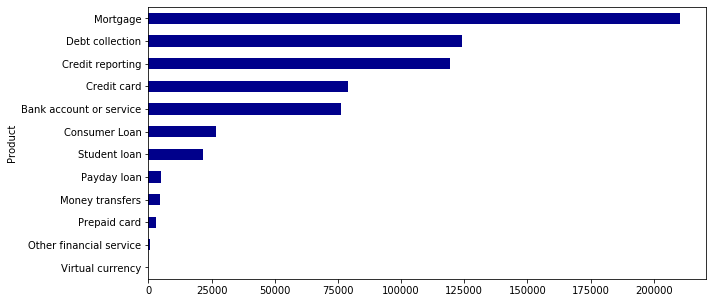

In [19]:
df.groupby('Product').size().sort_values()\
    .plot(kind='barh',figsize=(10,5),color='darkblue')

plt.show()

In [20]:
df.groupby('Product').size().sort_values(ascending=False)

Product
Mortgage                   210324
Debt collection            124236
Credit reporting           119195
Credit card                 79007
Bank account or service     76084
Consumer Loan               26604
Student loan                21651
Payday loan                  4786
Money transfers              4720
Prepaid card                 3171
Other financial service       806
Virtual currency               14
dtype: int64

### Distribución geográfica

Pasando a un análisis más profundo en el ámbito geográfico, podemos observar que una gran cantidad de registros se concentran en los primeros 4 estados. Sin embargo, hay que recordar que para este caso el tamaño y la densidad de población son los factores clave que determinan la distribución de casos.

California, Florida y Texas (los 3 primeros) son de los pocos estados que cubren un gran territorio  y poseen zonas densamente pobladas.
Por otra parte, el centro del país está relativamente vacío, a pesar de componerse por territorios de tamaño considerable. Estos cubren los estados con el menor número de registros.
Por úlitmo, los estados de la costa este se encuentran a la mitad de la distribución, debido a que están llenos de zonas densamente pobladas pero son de tamaño pequeño.

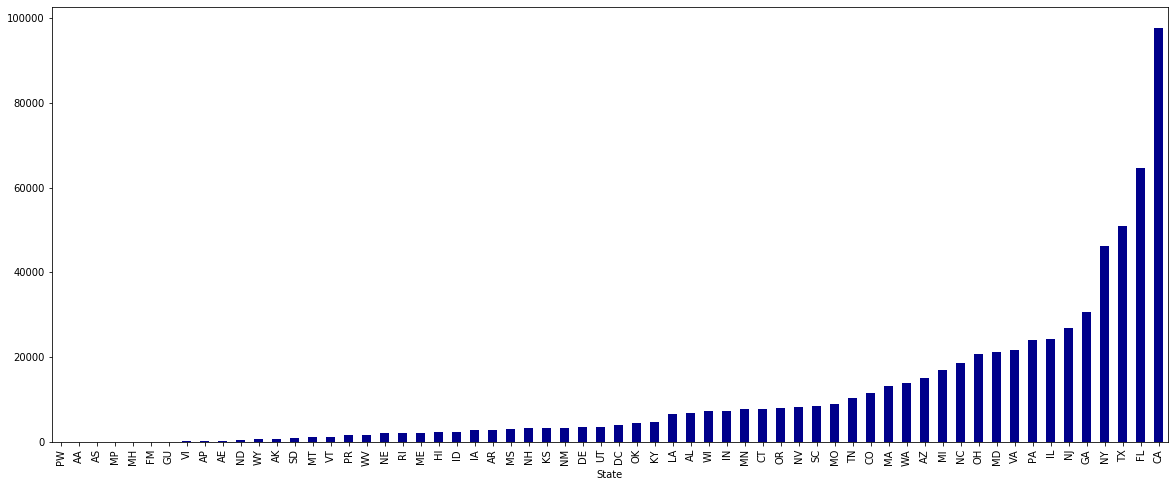

In [21]:
df.groupby('State').size().sort_values()\
    .plot(kind='bar',figsize=(20,8),color='darkblue')
plt.show()

In [22]:
aux=df.groupby('State').size().reset_index().rename(columns={0:'total_quejas_edo','State':'STUSPS'})
mapa=mapa.merge(aux,on='STUSPS')
del aux

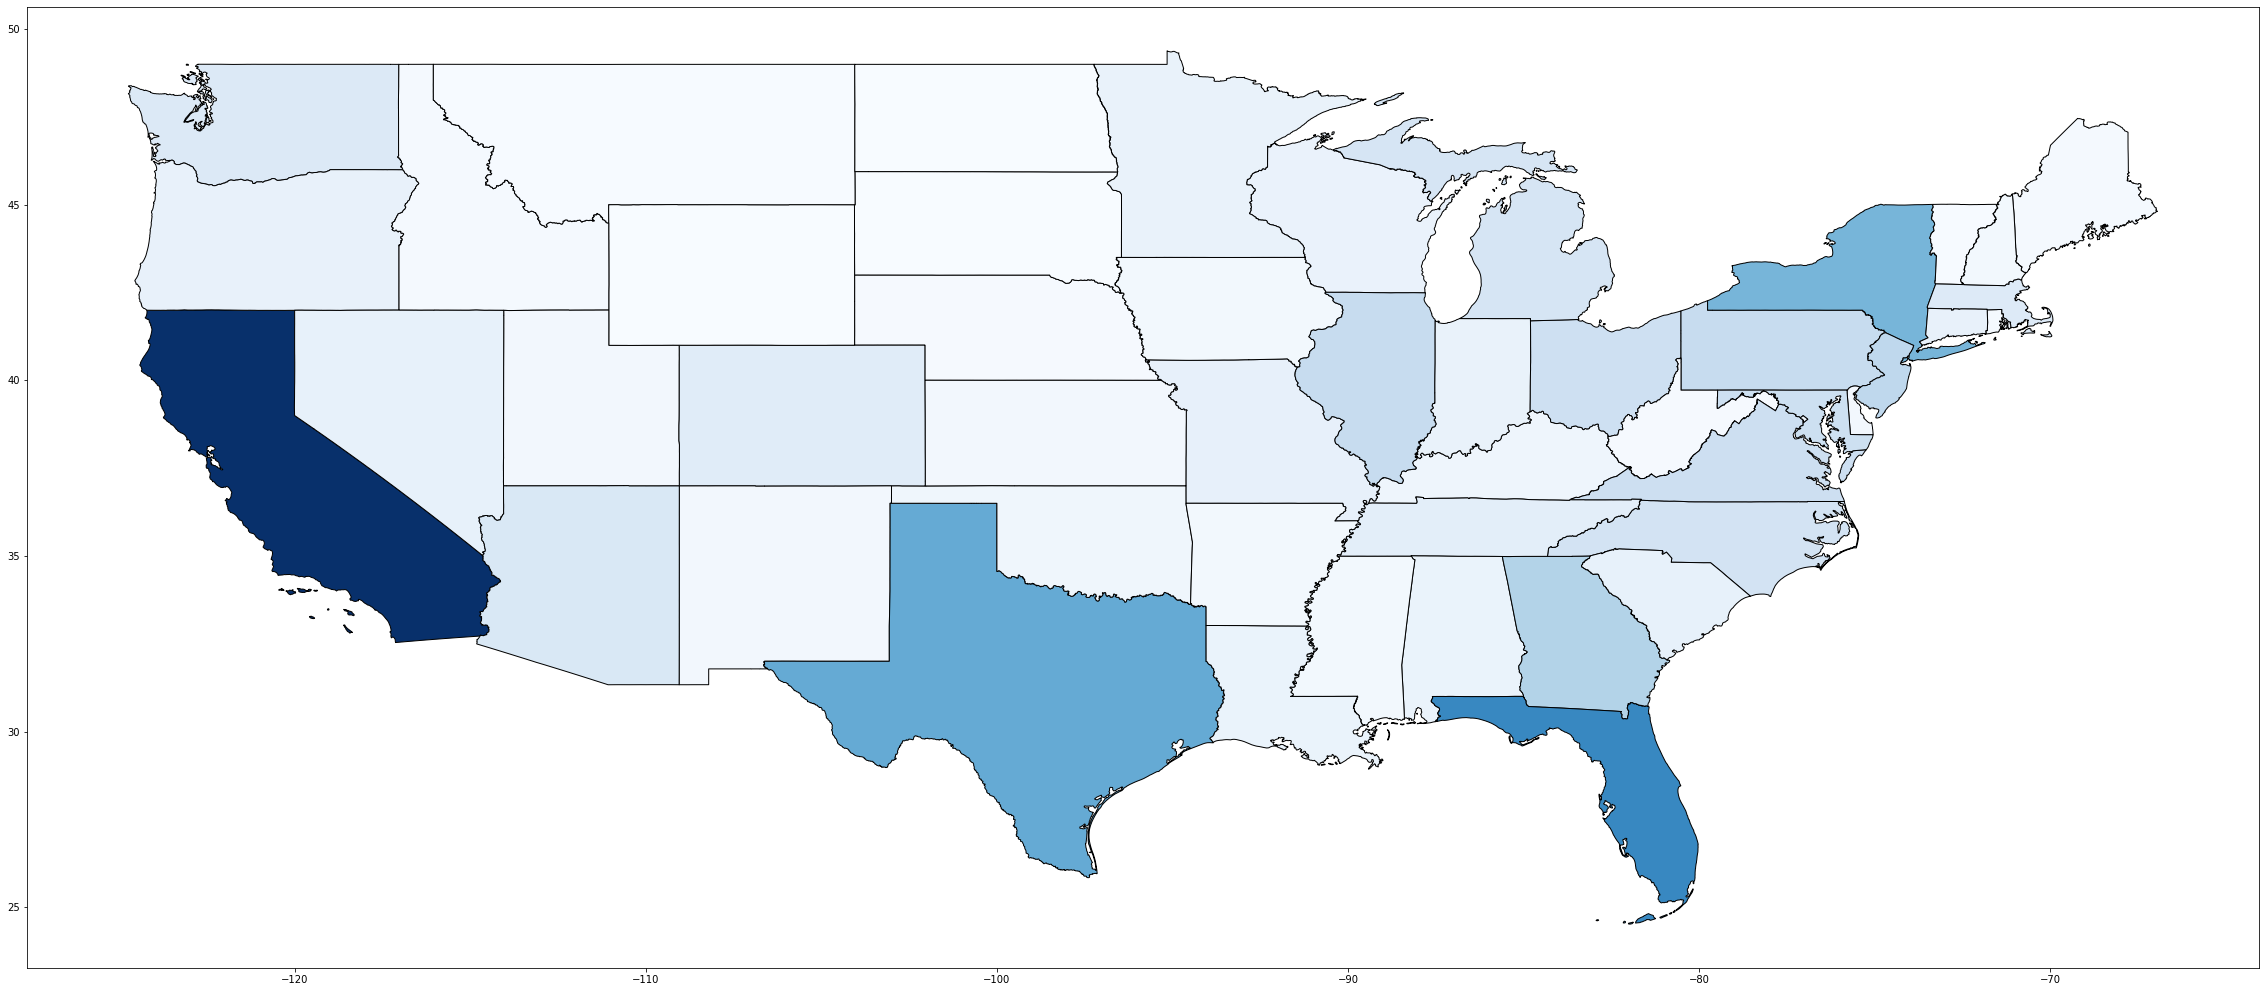

In [23]:
# omitimos las entidades fuera de la masa continental principal para la gráfica
mapa[~mapa['STUSPS'].isin(['GU','MP','PR','HI','AK','AS','VI'])]\
    .plot(column='total_quejas_edo',cmap='Blues',figsize=(40,30),edgecolor='black')
#plt.grid(b=None)
plt.show()

Ahora pasamos a visualizar los datos de manera más desagregada. De esta manera se puede observar puntos de concentración de quejas en lo que probablemente sean poblaciones urbanas.
Descomponiendo la información aún más, ahora con un mapa por registro, vemos que la distribución de quejas a lo largo del país no varía por producto:

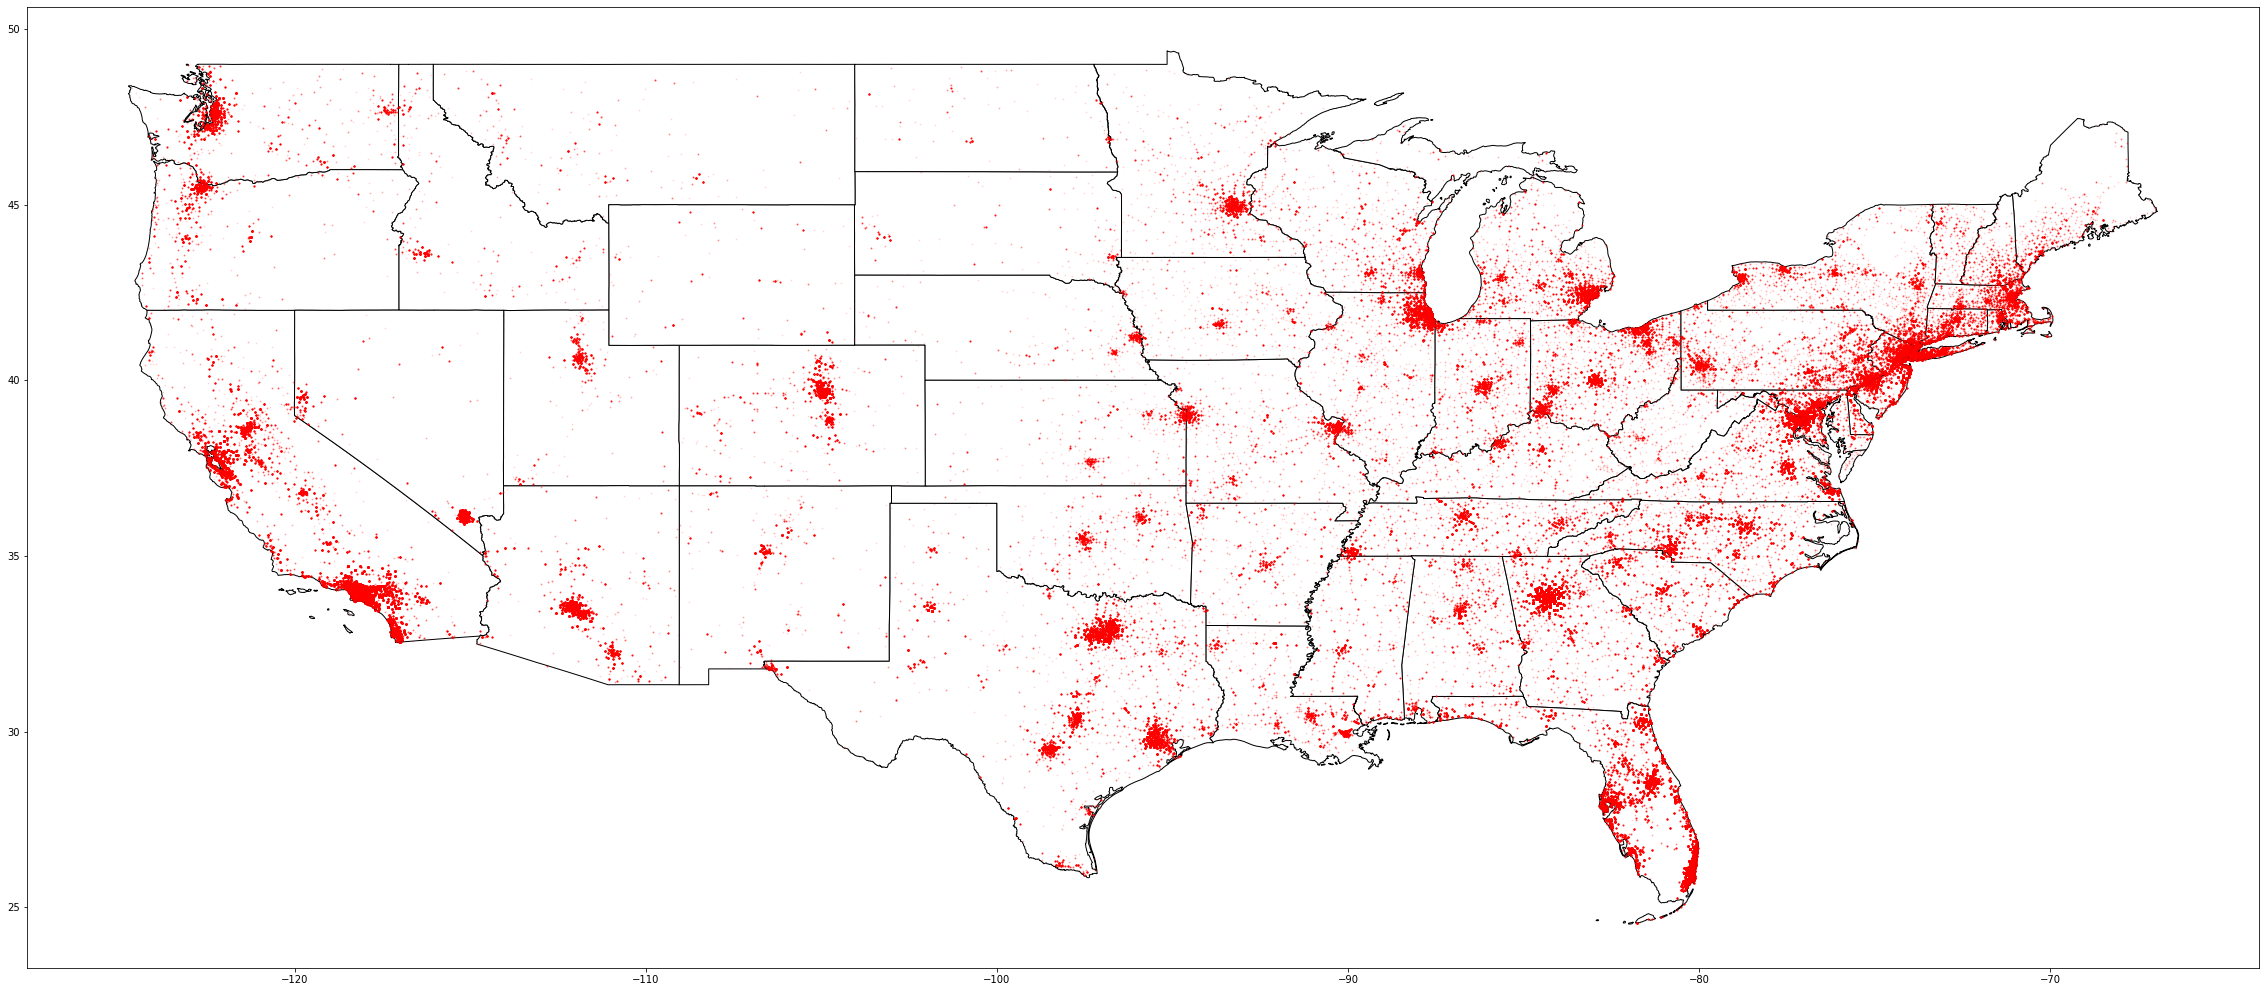

In [24]:
f, ax = plt.subplots(1,figsize=(40,30))

# Como el mapa incluye territorios fuera del conjunto principal (el más conocido Alaska, incluyendo otros desde Hawaii hasta Guam)
# los excluimos para la visualizacion

aux_territorio_princ = ~mapa['STUSPS'].isin(['GU','MP','PR','HI','AK','AS','VI'])
mapa[aux_territorio_princ].plot(ax=ax,color='white',edgecolor='black')
del aux_territorio_princ

# para excluir los puntos fuera del conjunto principal excluimos los puntos fuera de cierto intervalo de coordenadas

puntos.loc[(puntos['latitude']>22)&(puntos['latitude']<55)&(puntos['longitude']>-135)&(puntos['longitude']<-60)]\
    .plot(ax=ax,color='red',markersize=1,alpha=.1)#03)

plt.show()

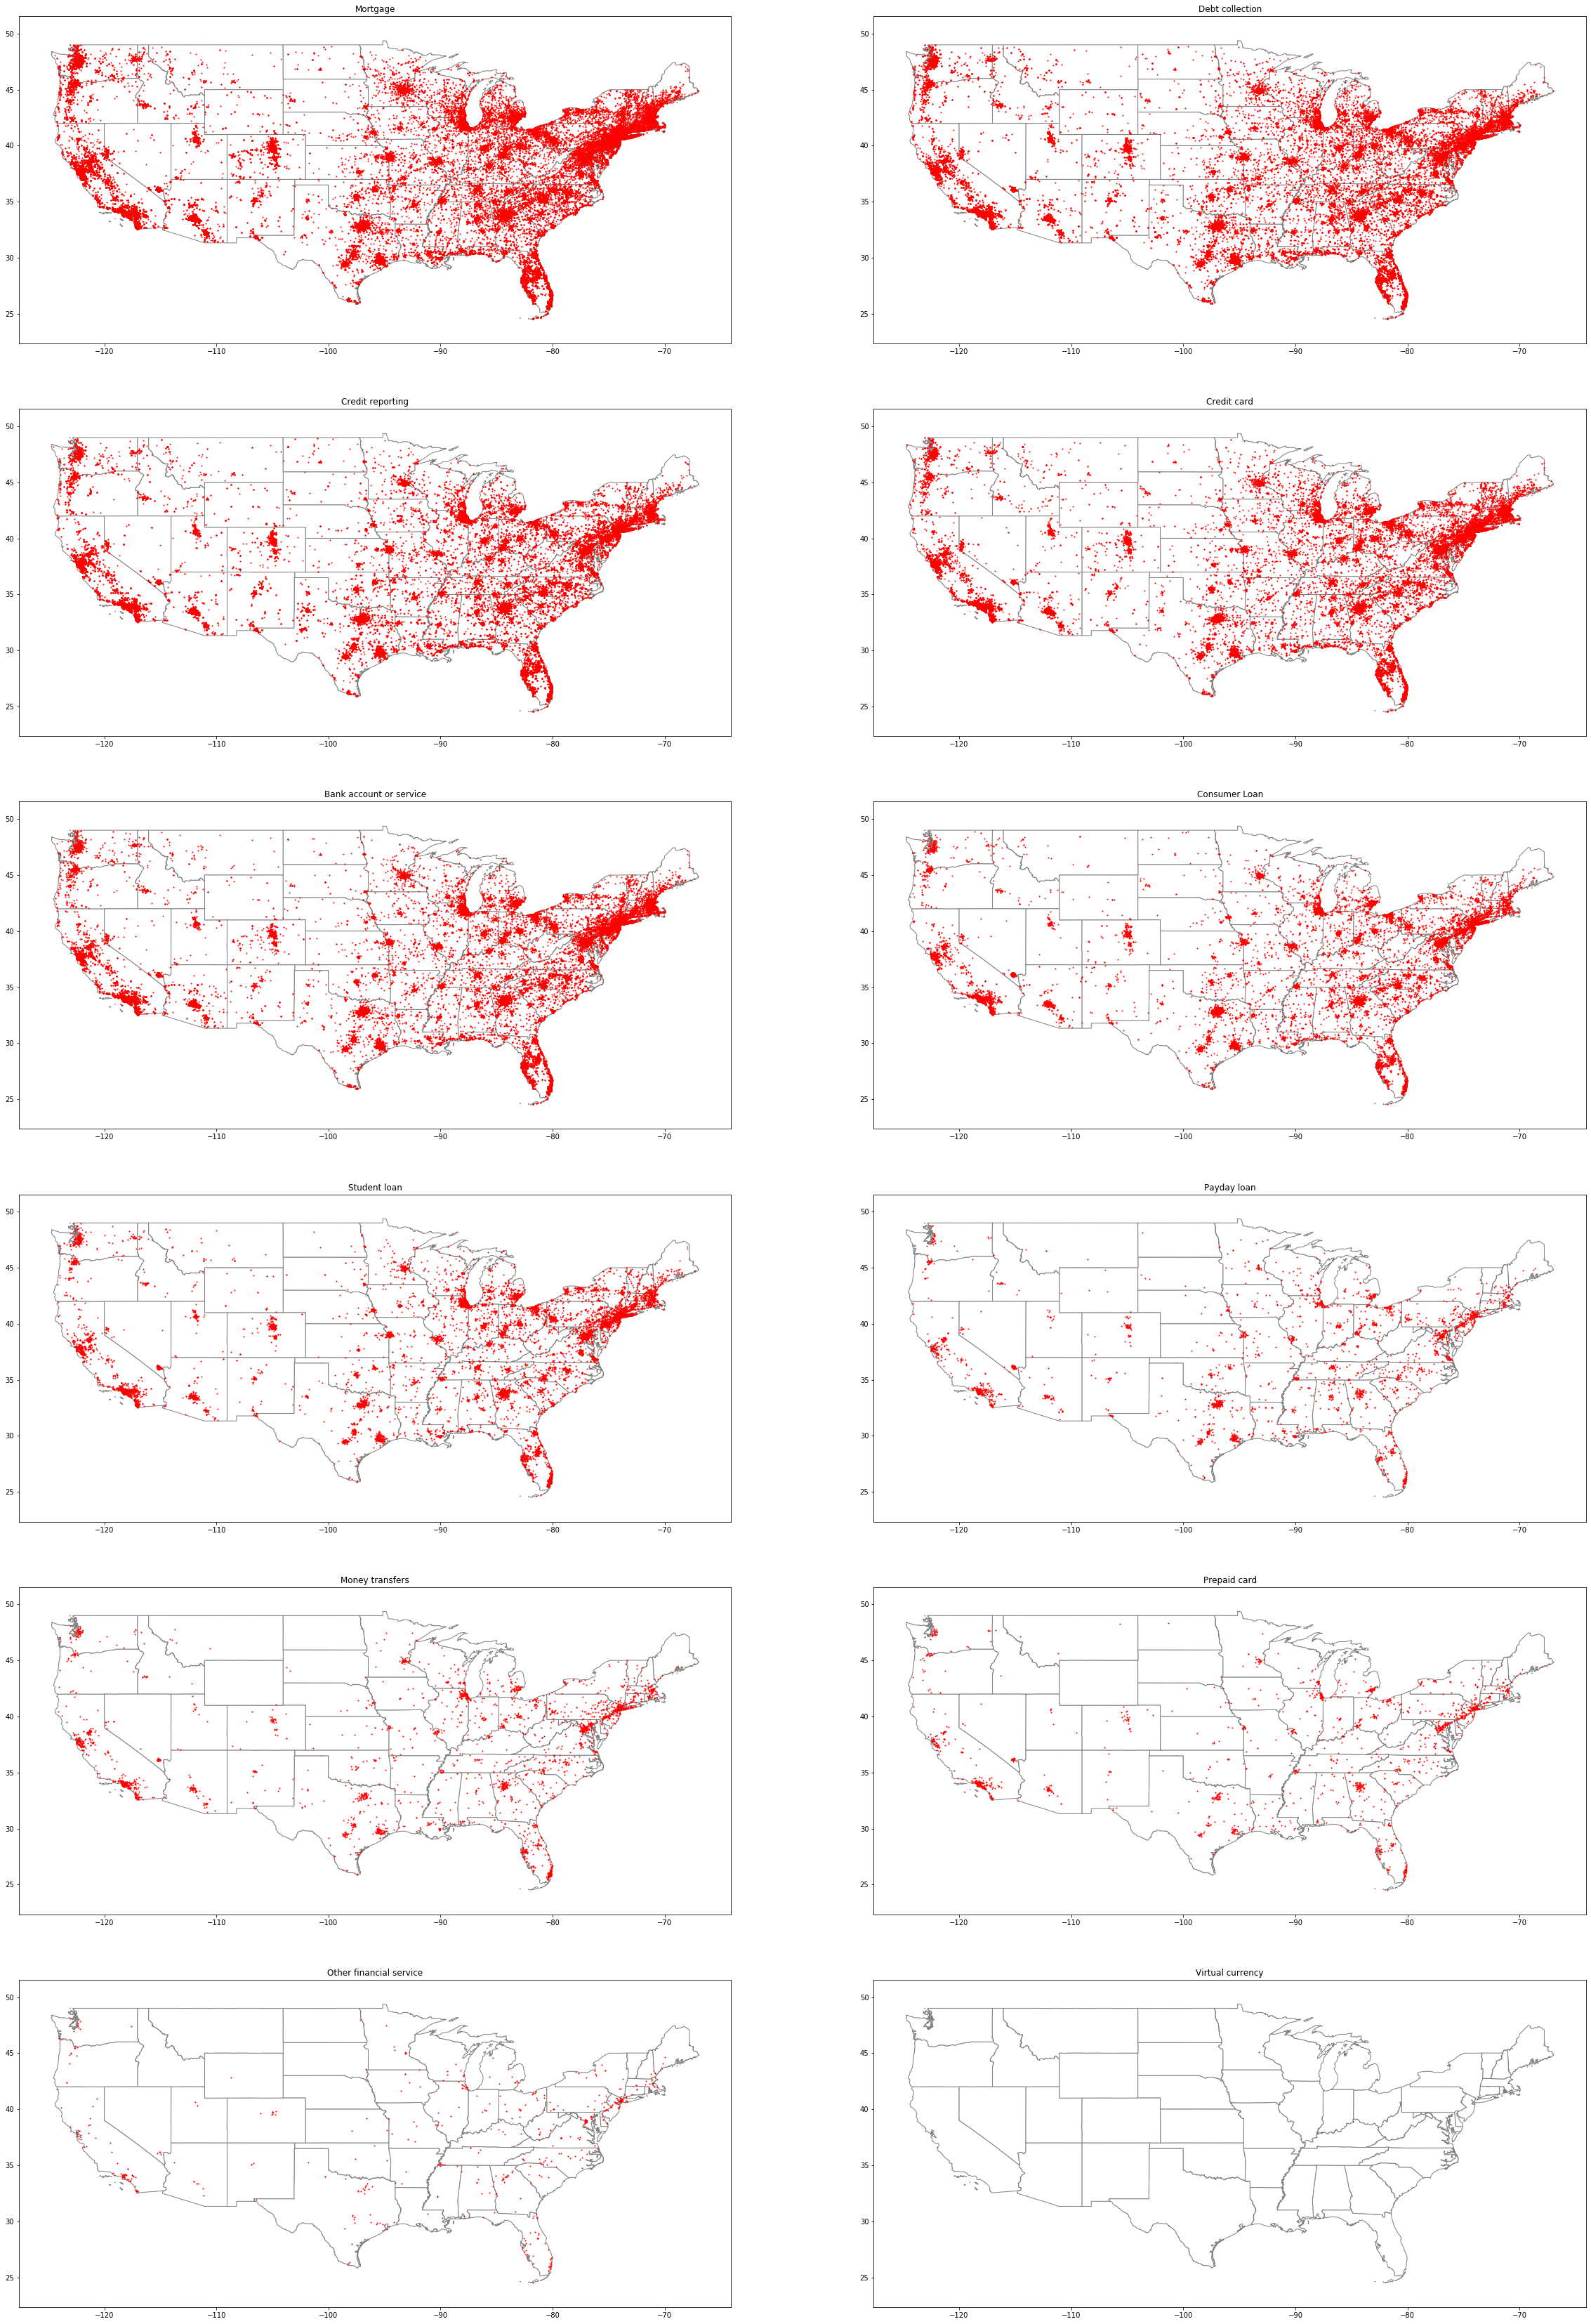

In [25]:
productos= df.groupby('Product').size().sort_values(ascending=False).index

plt.figure(figsize=(40,60))

for i in range(len(productos)):
    
    ax = plt.subplot(6, 2, i + 1)
    
    # mapa
    mapa[~mapa['STUSPS'].isin(['GU','MP','PR','HI','AK','AS','VI'])]\
        .plot(ax=ax,color='white', edgecolor='grey')
    
    # puntos
    puntos.loc[(puntos['latitude']>22)&(puntos['latitude']<55)&
               (puntos['longitude']>-135)&(puntos['longitude']<-60)&
               (puntos['Product']==productos[i])]\
        .plot(ax=ax,color='red',markersize=1,alpha=1)
    
    ax.set_title(productos[i])
    ax.set_aspect('equal', adjustable='datalim')

plt.show()

### Identificación de clusters

Para la identificación de zonas coconcentradoras de quejas, procedimos a ejecutar un algoritmo de aprendizaje no supervisado, específicamente una versión modificada del algoritmo BDSCAN.

Dado que hacemos la clusterización sobre las coordenadas de las quejas, las cuales provienen de su código zip, y naturalmente hay varios casos por zip, usamos esto a nuestro favor para ahorrar tiempo en el cálculo. En vez de aplicar el algoritmo a cada registro, lo aplicamos a cada codigo zip, tomando el número de quejas registradas en dicho código zip como peso.

Elección de parámetros
- Epsilon: Tamaño del buffer para identificar otras observaciones como vecinas. Tras inverstigar, se conoció que el tamaño promedio de una zona de un código postal era de 90 millas cuadradas. Tomando un territorio cuadrado da 9.48 millas para cada lado. Pasándolo a km da 15.17 km, lo que equivale aproximadamente a 1 grado en ambas coordenadas para la zona de México Estados Unidos (tomando en consideración que esto varía por zona geográfica, 1 grado no es la misma distancia en el ecuador que en el polo norte).
- Mínimo de elementos (m): Número mínimo de registros para considerar un conjunto de vecinos como un cluster. Se observó que la mayoría de los estados con menos registros tienen poco más de 2000. Dado que estos solo cuentan con un punto de concentración y unas pocas observaciones esparcidas en el resto de la zona, tomamos 2000 como nuestro parámetro.

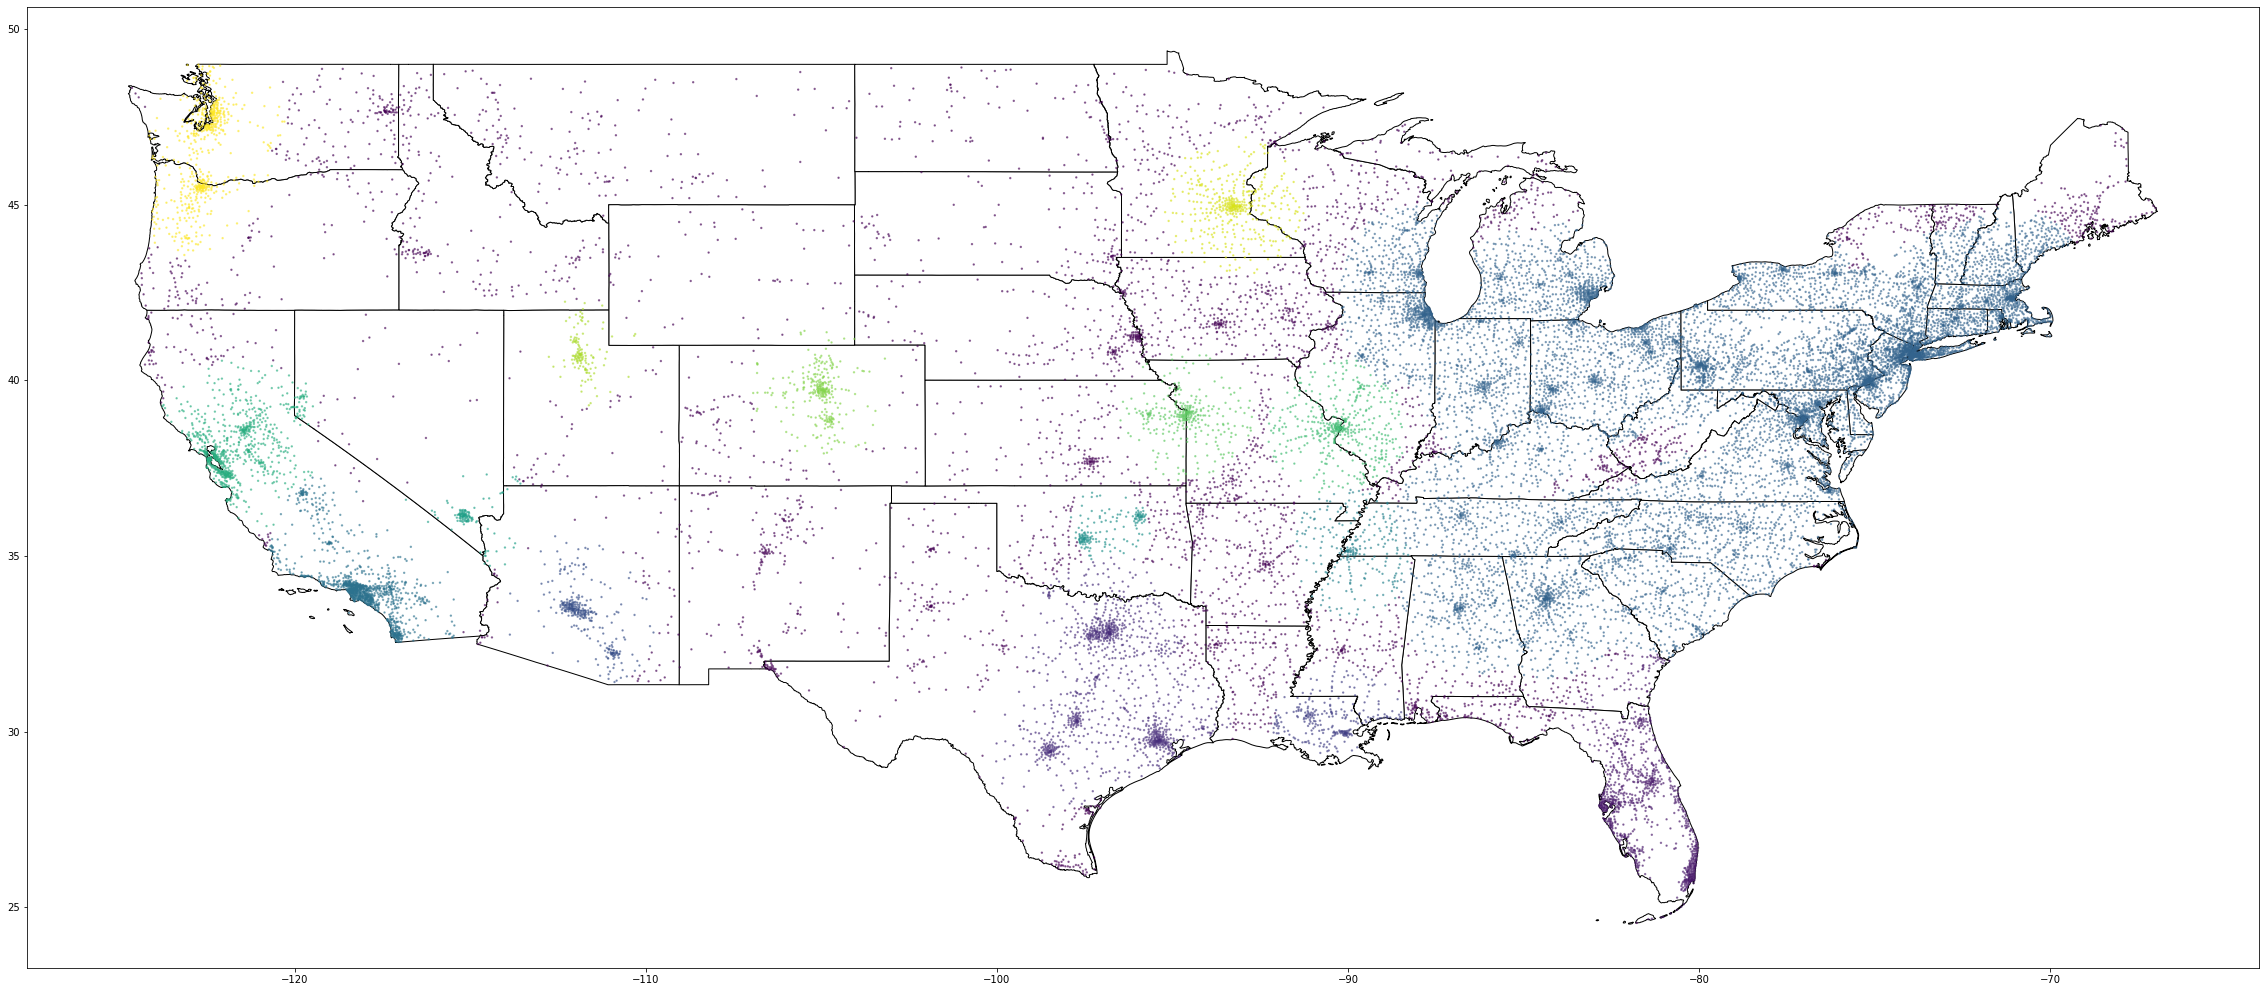

In [26]:

# clasificación no supervisada

# conteo de registros por zip
puntos_0=puntos.groupby(['latitude','longitude']).size().reset_index().rename(columns={0:'conteo'})

# BDScan pesado por registros por zip
clustering = DBSCAN(eps=1,
                    min_samples=2000)\
    .fit(np.array(puntos_0[['longitude','latitude']]),
        sample_weight=puntos_0['conteo'])

puntos_0['etiqueta']=clustering.labels_
puntos_0=puntos[['geometry','longitude','latitude']]\
    .drop_duplicates()\
    .merge(puntos_0,on=['longitude','latitude'])

##########################################

# gráfica

f, ax = plt.subplots(1,figsize=(40,30))

# Como el mapa incluye territorios fuera del conjunto principal (el más conocido Alaska, incluyendo otros desde Hawaii hasta Guam)
# los excluimos para la visualizacion

aux_territorio_princ = ~mapa['STUSPS'].isin(['GU','MP','PR','HI','AK','AS','VI'])
mapa[aux_territorio_princ].plot(ax=ax,color='white',edgecolor='black')
del aux_territorio_princ

# para excluir los puntos fuera del conjunto principal excluimos los puntos fuera de cierto intervalo de coordenadas

#puntos.loc[(puntos['latitude']>22)&(puntos['latitude']<55)&(puntos['longitude']>-135)&(puntos['longitude']<-60)]\
#    .plot(ax=ax,color='red',markersize=1,alpha=.1)#03)

aux_territorio_princ_0 = (puntos_0['latitude']>22)&(puntos_0['latitude']<55)&(puntos_0['longitude']>-135)&(puntos_0['longitude']<-60)

puntos_0[aux_territorio_princ_0]\
    .plot(ax=ax,
          column=puntos_0.loc[aux_territorio_princ_0,'etiqueta'],
          markersize=2,
         alpha=.5)

plt.show()

Podemos notar que los clusters correspondían a regiones amplias, como uno que comprende toda la costa noreste. Con la esperanza de identificar clusters por ciudades y sus áreas metropolitanas, tomamos un caso con valores más pequeños. Partiendo de un mínimo de elelmentos de 500 por cluster, calculamos la distancia promedio entre cada elemento y sus 500 vecinos. Ordenándolos , observamos que se da un punto de inflexión en 0.25 aproximadamente. Tomamos dicho valor como epsilon y procedemos a ejecutar el algoritmo, con resultados favorables.

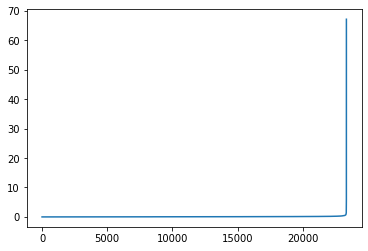

In [27]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=500)
neighbors_fit = neighbors.fit(np.array(puntos_0[['longitude','latitude']]))
distances, indices = neighbors_fit.kneighbors(np.array(puntos_0[['longitude','latitude']]))

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

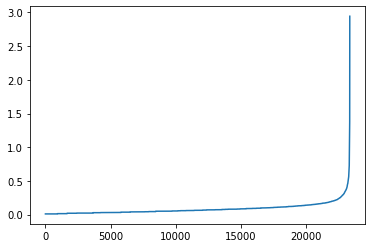

In [28]:
plt.plot(distances[:23340])
plt.show()

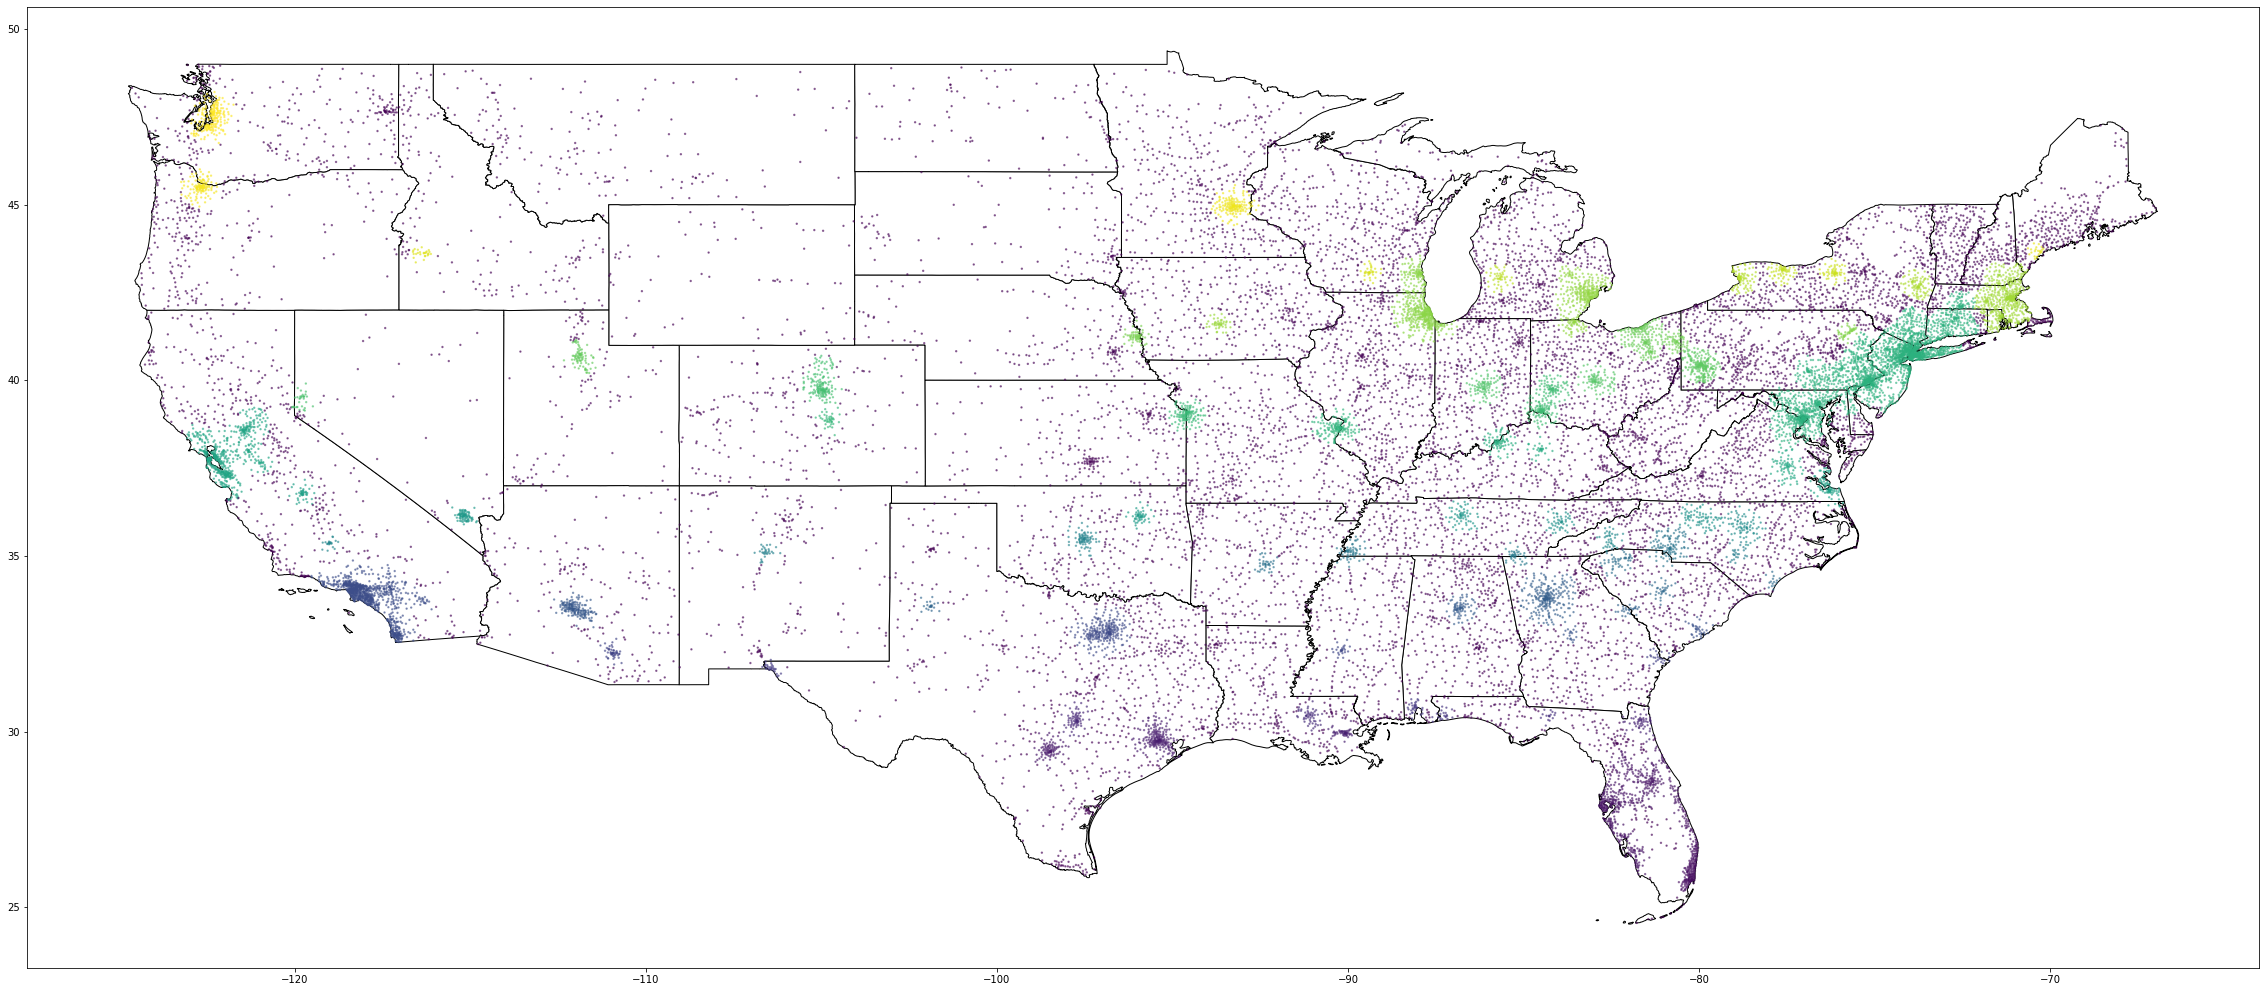

In [29]:

# clasificación no supervisada

# conteo de registros por zip
puntos_0=puntos.groupby(['latitude','longitude']).size().reset_index().rename(columns={0:'conteo'})

# BDScan pesado por registros por zip
clustering = DBSCAN(eps=.25,
                    min_samples=500)\
    .fit(np.array(puntos_0[['longitude','latitude']]),
        sample_weight=puntos_0['conteo'])

puntos_0['etiqueta']=clustering.labels_
puntos_0=puntos[['geometry','longitude','latitude']].drop_duplicates()\
    .merge(puntos_0,on=['longitude','latitude'])

##########################################

# gráfica

f, ax = plt.subplots(1,figsize=(40,30))

# Como el mapa incluye territorios fuera del conjunto principal (el más conocido Alaska, incluyendo otros desde Hawaii hasta Guam)
# los excluimos para la visualizacion

aux_territorio_princ = ~mapa['STUSPS'].isin(['GU','MP','PR','HI','AK','AS','VI'])
mapa[aux_territorio_princ].plot(ax=ax,color='white',edgecolor='black')
del aux_territorio_princ

# para excluir los puntos fuera del conjunto principal excluimos los puntos fuera de cierto intervalo de coordenadas

#puntos.loc[(puntos['latitude']>22)&(puntos['latitude']<55)&(puntos['longitude']>-135)&(puntos['longitude']<-60)]\
#    .plot(ax=ax,color='red',markersize=1,alpha=.1)#03)

aux_territorio_princ_0 = (puntos_0['latitude']>22)&(puntos_0['latitude']<55)&(puntos_0['longitude']>-135)&(puntos_0['longitude']<-60)

puntos_0[aux_territorio_princ_0]\
    .plot(ax=ax,
          column=puntos_0.loc[aux_territorio_princ_0,'etiqueta'],
          markersize=2,
         alpha=.5)

plt.show()

# Normalización de bancos

In [30]:
company=df['company_0'].drop_duplicates().values.tolist()

In [31]:
# computamos una especie de matriz de distancias, normalizado por la longitud de la palabra mas chica
# dado que es simetrica, solo calculamos la mitad triangular superior

start = time.time()

dist_mat=np.ones((len(company),len(company)))-np.identity(len(company))
for i in (range(len(company))):
    for j in (range( i+1,len(company) ) ):
#    for j in (range(len(company)) ):
        dist_mat[i,j]=editdistance.eval(company[i],company[j])/min(len(company[i]),len(company[j]))
            
end = time.time()
print((end - start)/60)

0.6074279030164083


In [32]:
start = time.time()

# total es el total de elementos en la lista
# le iremos quitando elementos en cada iter hasta vaciarlo

def list_diff(li1,li2):
    r=[i for i in li1 if i not in li1 or i not in li2]
    return r;

vv=[]
total=list(range(len(company)))
max_dist=.25

while ( len(total)>0 ):

    # tomamos el primer elemento de total y con ello el cjto inicial de elementos parecidos a este
    v=np.where(dist_mat[total[0],:]<max_dist)[0].tolist()
    v=list_diff(v,list(range(total[0])))
#    v=dist_mat[total[0],dist_mat[total[0],:]<.25]
    
    if (len(v)>1):
    
        i=0
        limite=len(v)-1
    
    # de manera iterativa, si el elemento parecido tiene elementos parecidos, los añadimos al conjunto
    # en la cola, de esta forma posteriormente evaluaremos si estos a su vez tienen elementos similares
    # o no. acto seguido actualizamos el limite, puesto que el conjunto creció, y pasamos el siguiente
    # elemento parecido
    # cuando agotemos los elementos similares alcancaremos el limite y terimnaremos con un conjunto v
    # donde todos los elementos en v son similares entre si y no hay ninguno afuera parecido a ellos
    
        while (i<=limite):
            a = np.where(dist_mat[v[i],:]<max_dist)[0].tolist()
            a = list_diff(a,[v[i]])
            a = list_diff(a,v)
            if ( len(a)>0 ) :            
                v+=a
                lim=len(v)
            i+=1

    # una vez hecho esto añadimos este conjunto v a la lsita de conjuntos vv y eliminamos sus elementos
    # de la lista total

    # notese como en la siguiente iteracion total[0] tomará otro valor
    # de cierta forma, eliminar los elementos de v de total ejecuta una especie de for indirecto
    v=list_diff(v,list(range(total[0])))
    if( len(v)>1 ):
        vv.append(v)
        
    total=list_diff(total,v)
    
end = time.time()
print((end - start)/60)

1.6562445918718973


A continuación mostramos los bancos agrupados (nótese como solo imprimimos una parte para evitar saturar):

In [33]:
vvv=[]
for j in range(len(vv)):
    vvv.append([company[i] for i in vv[j]])

vvv[:5]

[['FRANKLIN CREDIT MANAGEMENT', 'GENESIS CREDIT MANAGEMENT'],
 ['NRA GROUP', 'DTA GROUP', 'NPS GROUP', 'JVS GROUP'],
 ['NAVIENT SOLUTIONS', 'BAYVIEW SOLUTIONS'],
 ['LAND/HOME FINANCIAL SERVICES',
  'LENDMARK FINANCIAL SERVICES',
  'FLAGSTONE FINANCIAL SERVICES',
  'LINCOLN FINANCIAL SERVICES',
  'KEYHOLE FINANCIAL SERVICES',
  'MERIDIAN FINANCIAL SERVICES',
  'SENTRIX FINANCIAL SERVICES',
  'CONSTAR FINANCIAL SERVICES',
  'WEICHERT FINANCIAL SERVICES',
  'CENTURY FINANCIAL SERVICES',
  'LENNAR FINANCIAL SERVICES',
  'RICART FINANCIAL SERVICES',
  'MEDICAL FINANCIAL SERVICES',
  'FEDERAL FINANCIAL SERVICES',
  'STEWARD FINANCIAL SERVICES',
  'VENTURE FINANCIAL SERVICES',
  'ACTION FINANCIAL SERVICES',
  'GRASSLAND FINANCIAL SERVICES',
  'FUTURE FINANCIAL SERVICES',
  'INSIGHT FINANCIAL SERVICES'],
 ['ALLY FINANCIAL',
  'AXIA FINANCIAL',
  'AMOS FINANCIAL',
  'LUNA FINANCIAL',
  'DMB FINANCIAL']]

In [34]:
#flat_list = []
#for vv in vvv:
#    for bank in vv:
#        flat_list.append(bank)
#
#flat_list_0 = []
#for vv in vvv:
#    for i in range(len(vv)):
#        flat_list_0.append(vv[0])
#
#company_norm=pd.DataFrame({'company_0':flat_list,'company_1':flat_list_0})
#
#df.merge(company_norm,on='company_0',how='left')\
#    .groupby('company_1').size().sort_values()\
#    .plot(kind='barh',figsize=(5,50),color='darkblue')
#plt.show()

## Procesamiento de texto

Para obtener visualizaciones del texto adjunto a los registros, este pasará por un procesamiento en donde eliminaremos palabras triviales, signos de puntuación, entre otras cosas.
Primero aplicaremos un algoritmo de stemming, el cual quita los sufijos a las palabras para homogeneizarlas, ya que con esto se les despoja de sus conjugaciones. Este ejercicio es algo tardado (el comando tardó casi 6 min en ejecutarse).

In [35]:
comentarios=df[df['Consumer complaint narrative'].notnull()]['Consumer complaint narrative'].copy().str.lower()

st = PorterStemmer()
start = time.time()

comentarios_stem = []
for comentario in comentarios:
    comentarios_stem.append(" ".join([st.stem(i) for i in comentario.split()]))

end = time.time()
print((end - start)/60)

6.253353607654572


In [36]:
df['text']=df['Consumer complaint narrative'].copy()
df.loc[df['text'].notnull(),'text']=comentarios_stem
df.loc[df['text'].notnull(),'text']=df.loc[df['text'].notnull(),'text']\
    .str.lower()\
    .str.replace('{.+}','').str.replace('xxxx','').str.replace('\.','').str.replace('\,','')\
    .str.replace('\(','').str.replace('\)','')\
    .str.replace('    ',' ').str.replace('   ',' ').str.replace('  ',' ')

Una vez procesado el texto, mostraremos la nube de palabras para cada producto, en donde se toman las palabras más comunes para cada categoría:

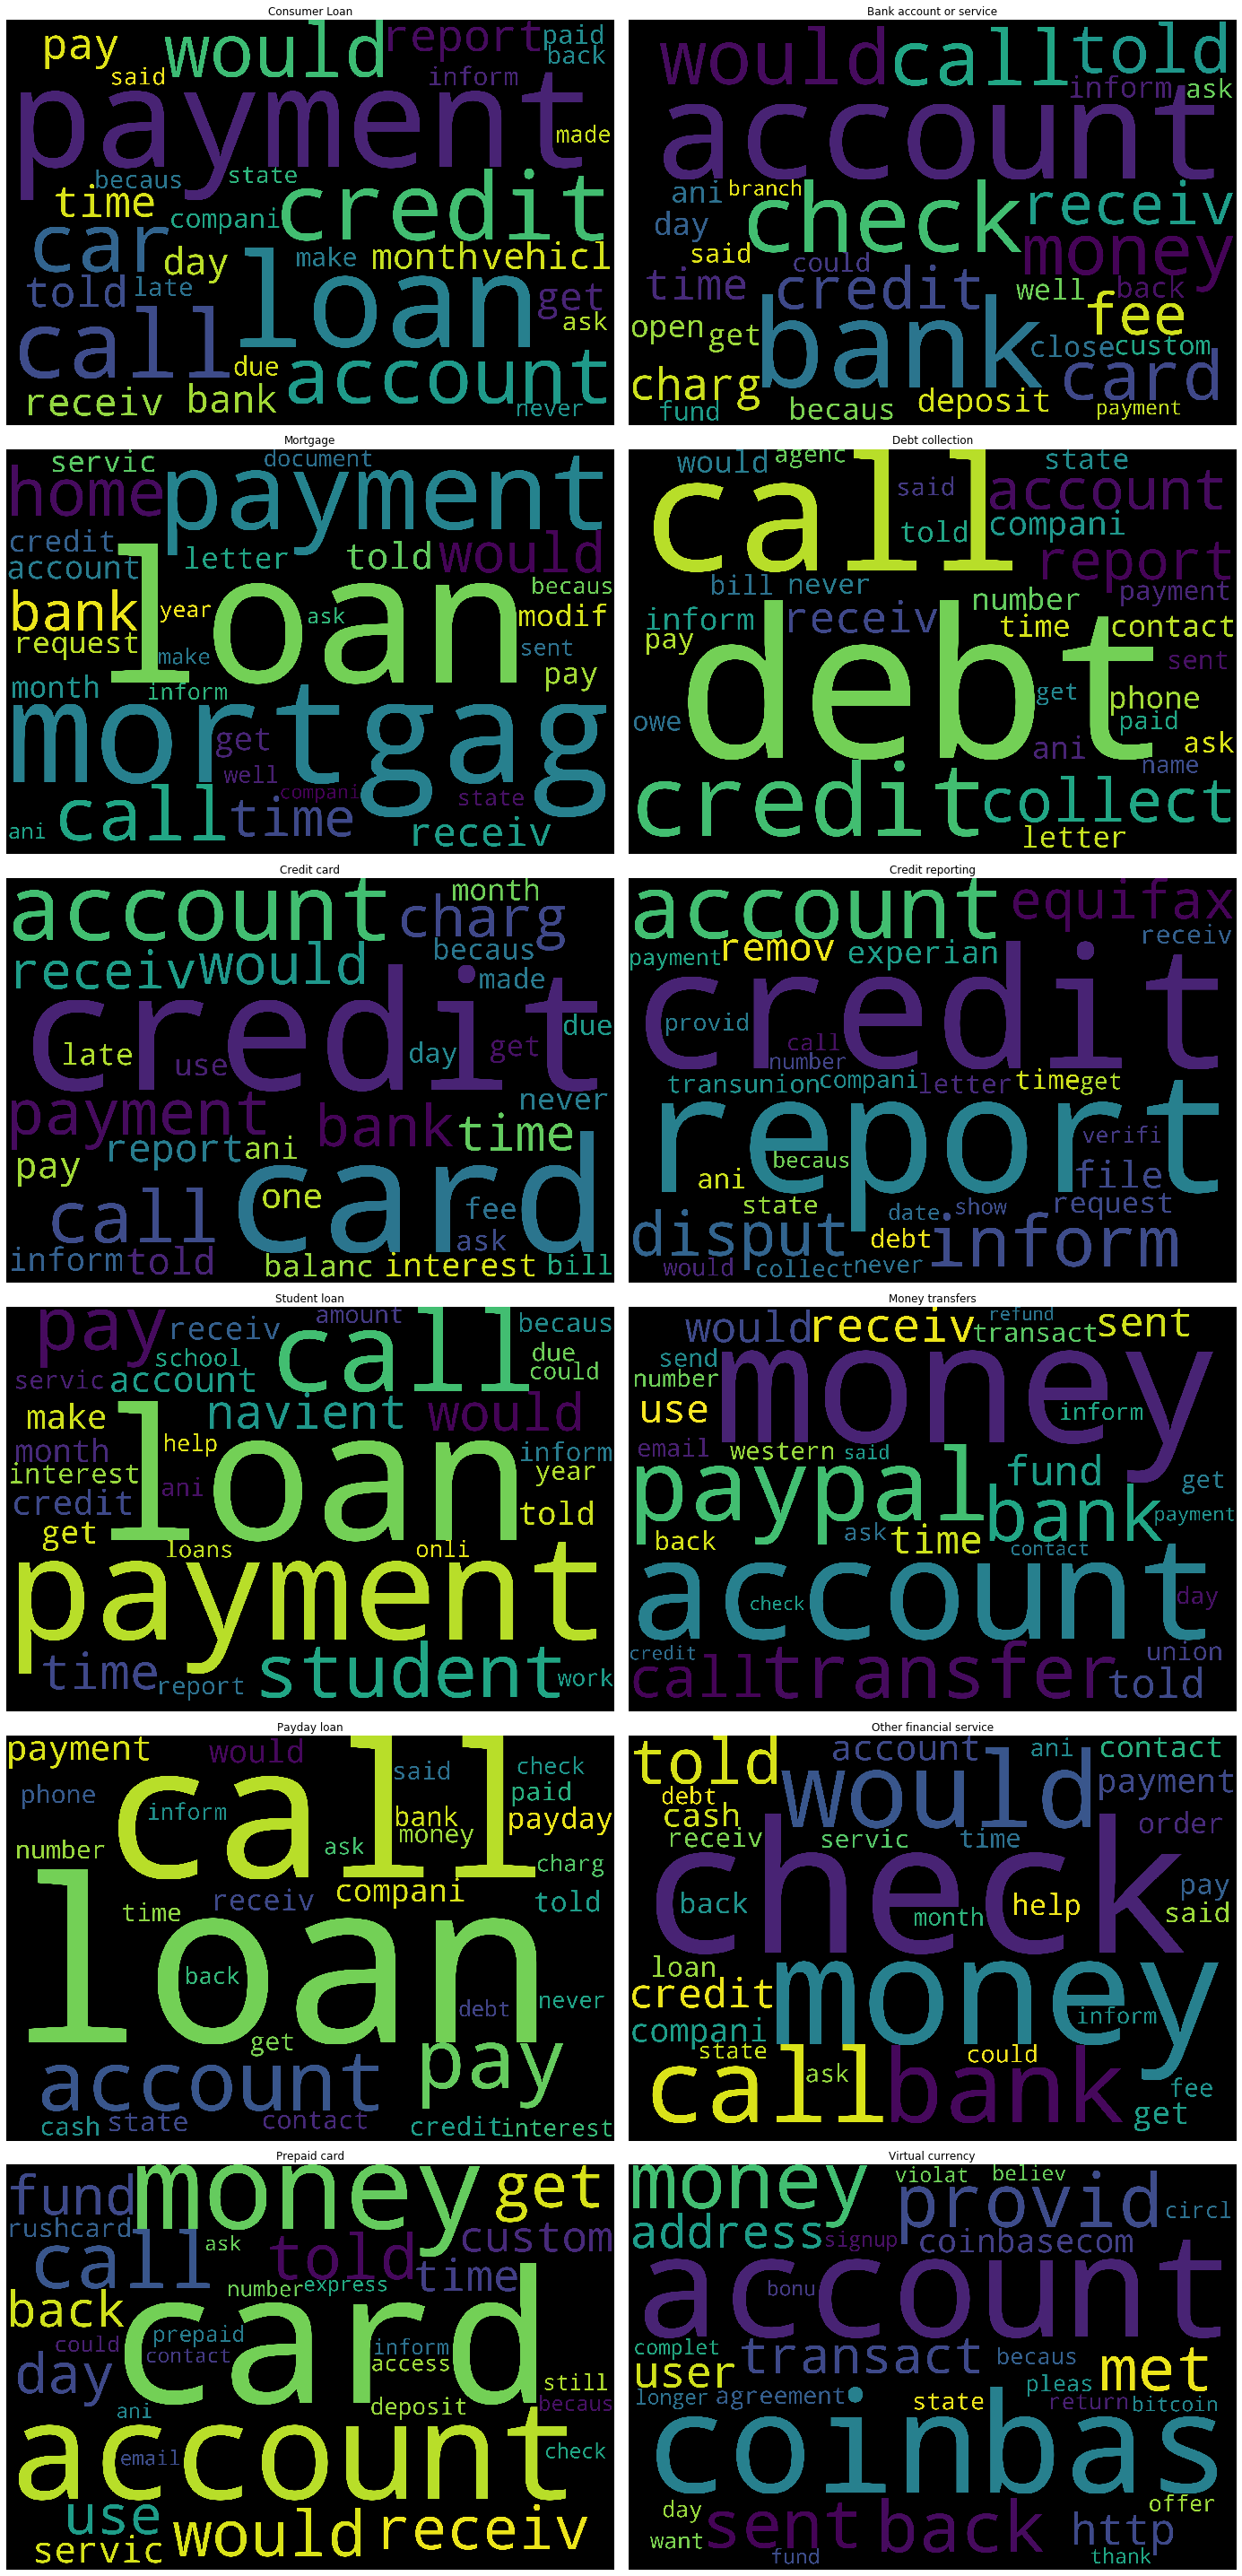

In [37]:
productos=df['Product'].drop_duplicates().tolist()

plt.figure(figsize=(20,40))

for i in range(len(productos)):
    
    ax = plt.subplot(len(productos)/2, 2, i + 1)
    
  #   genera base de variables indicadoras por palabra
  #def base_vec_palabras(OPS,col_palabras,col_animo,animo):
  # V es una matriz
    vectorizer=CountVectorizer()
    V = vectorizer.fit_transform(df[df['text'].notnull()][df['Product']==productos[i]]['text'].values.astype('U'))
    # lista de palabras
    lista_palabras = vectorizer.get_feature_names()
  #  conteo de palabras
    conteo_lista_palabras=pd.Series(V.sum(axis=0).tolist()[0],index=lista_palabras)
    conteo_lista_palabras_3 = conteo_lista_palabras.iloc[np.where(pd.Series(
                                                            [len(omg) for omg in conteo_lista_palabras.index.values.tolist()]
                                                            )>2)]
  # subset de utiles
    lista_palabras_subset = list(
    set(conteo_lista_palabras_3.index.values.tolist()
    ).difference(
        set(palabras_inutiles)
    ).difference(
        set(['i','thi','&'])
    ))
    freqs=conteo_lista_palabras_3[lista_palabras_subset]
    wc=WordCloud(width=3000,height=2000,max_words=30,random_state=1,
              prefer_horizontal=1,collocations=False,stopwords=None)\
      .generate_from_frequencies(freqs.sort_values(ascending=False)[:30])

    
    ax.imshow(wc)
    ax.axis('off')
    ax.set_title(productos[i])

plt.tight_layout()
plt.show()

del productos

## Modelo NLP

Para la clasificación de registros de acuerdo al texto usaremos el modelo de Naive Bayes con distribución Bernoulli. Este es conveniente dado que funciona bien con datos con observaciones escasas en una gran cantidad de variables (sparse matrix), donde aparte tomamos cada ocurrencia en un registro como una variable binaria.

En ella quitaremos las palabras cortas (con menos de 3 caracteres) o consideradas inútiles (por ejemplo preposiciones) para mejorar nuestras predicciones.

Además de esto, omitiremos las categorías de criptomonedas y otros servicios financieros, ya que casi no tienen observaciones.

In [38]:
# V es una matriz
vectorizer=CountVectorizer()

categorias_pequeñas=['Virtual currency','Other financial service']

V = vectorizer.fit_transform(df[df['text'].notnull()][~df['Product'].isin(categorias_pequeñas)]['text']\
                            .values.astype('U'))
V = np.ceil(V/1000)

# lista de palabras
lista_palabras = vectorizer.get_feature_names()

#  conteo de palabras
conteo_lista_palabras=pd.Series(V.sum(axis=0).tolist()[0],index=lista_palabras)
conteo_lista_palabras_2 = conteo_lista_palabras#.where(conteo_lista_palabras>=20).dropna()
conteo_lista_palabras_3 = conteo_lista_palabras_2.iloc[np.where(pd.Series(
                                                          [len(omg) for omg in conteo_lista_palabras_2.index.values.tolist()]
                                                          )>2)]
  # subset de utiles
lista_palabras_subset = list(
    set(conteo_lista_palabras_3.index.values.tolist()
    ).difference(
        set(palabras_inutiles)
    ).difference(
        set(['i','thi','&'])
    ))

freqs=conteo_lista_palabras_3[lista_palabras_subset]

In [39]:
X=V[:,np.where(conteo_lista_palabras[conteo_lista_palabras[lista_palabras_subset]])[0]]
y=df[df['text'].notnull()][~df['Product'].isin(['Virtual currency','Other financial service'])]['Product']

Accuracy promedio con alpha=0.0625: %69.42887199808571
Accuracy promedio con alpha=0.125: %70.08815591211234
Accuracy promedio con alpha=0.25: %70.08465727062429
Accuracy promedio con alpha=0.49999999999999994: %69.3659862251424
Accuracy promedio con alpha=1.0: %68.57742468791768
Accuracy promedio con alpha=2.0000000000000004: %66.47992295289103
Accuracy promedio con alpha=3.999999999999999: %62.29536072604064
Accuracy promedio con alpha=7.999999999999999: %56.02028793942664
Accuracy promedio con alpha=16.0: %47.76725146049013


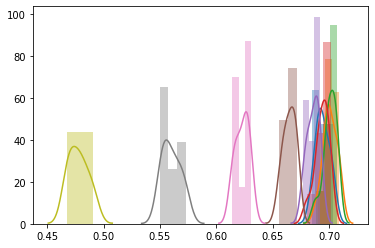

In [40]:
#for j in [0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16]:
for j in np.geomspace(1/2**4,2**4,4+4+1):

    modelo = BernoulliNB(alpha=j)
  # by_multi.fit(arreglo_train,OPSS['razon_animo'][:30000])
  # prediccion=by_multi.predict(arreglo_test).tolist()

    aux=cross_val_score(modelo,
                      X, y, cv=10)
    sns.distplot(aux)
    print( 'Accuracy promedio con alpha=' + str(j) + ': %' + str(100*aux.mean()))

    del aux

  # conteo = 0
  # for i in range(len(real)):
  #   if real[i]==prediccion[i]:
  #     conteo+=1
  # print(conteo)

El mejor score se encuentra alrededor de alpha=0.125, por lo que nos quedamos con ese valor.
Como este ejercicio solo se va a ocupar para los datos ya observados y no para predicción, tomamos la muestra completa en la estimación final.

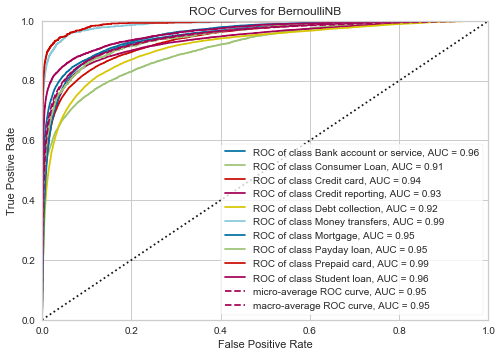

In [41]:
from yellowbrick.classifier import ROCAUC

by_multi = BernoulliNB(alpha=.125)
by_multi.fit(X,y)

#fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(by_multi)
roc_viz.score(X, y)
roc_viz.poof()
plt.show()

In [42]:
by_multi.score(X,y)

0.7395385797617801

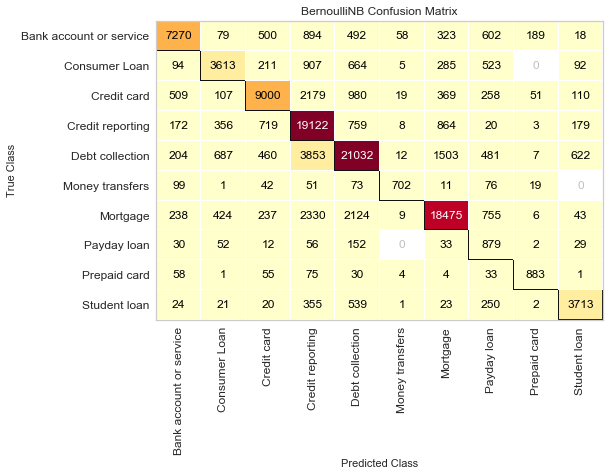

In [43]:
from yellowbrick.classifier import ConfusionMatrix
cm_viz = ConfusionMatrix(by_multi)
cm_viz.score(X,y)
cm_viz.poof()
plt.show()

In [44]:
prediccion=by_multi.predict(X).tolist()
pd.DataFrame({'real':y,'predicted':prediccion}).head()

real                predicted
57729       Credit card             Student loan
57787   Debt collection          Debt collection
57838       Credit card  Bank account or service
57848  Credit reporting         Credit reporting
57852   Debt collection          Debt collection